# Prerequisites

In [2]:
#!sudo apt update
#!sudo apt-get install libopenmpi-dev mpich
#!python -m pip install mpi4py
#!python -m pip install petsc
#!python -m pip install petsc4py
#import petsc
#!pip install control

In [2]:
# Definitions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from matplotlib.animation import FuncAnimation

def animate_dynamic_point(trajectory, resolution_Hz=15, duration=None, fig_size=8):
    plt.ioff()
    trajectory = np.array(trajectory)
    trajectory = trajectory.T[:40].T
    if len(trajectory.shape) == 1:
        trajectory = trajectory.reshape(trajectory.size, 1)
    if trajectory.shape == (trajectory.size, 1):
        trajectory = np.stack((trajectory.T[0], np.zeros(trajectory.size))).T
    if duration == None:
        frames = range(trajectory.shape[0])
    else:
        frames = range(int(duration * resolution_Hz))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    # set the axes limits
    ax.axis([-2,2,-2, 2])
    ax.set_aspect("equal")
    # create a point in the axes
    plt.grid()
    ax.plot(0, 0, markersize=108, marker="o", color = 'red')

    plt.text(0, 0, 'Target', horizontalalignment='center', verticalalignment='center', color='white')
    points = [ax.plot(0,1, marker="o")[0] for _ in range(20)]

    # Updating function, to be repeatedly called by the animation
    def update(t):
        # obtain point coordinates
        x12 = trajectory[int(t) % trajectory.shape[0]][:40]
        # set point's coordinates
        for i in range(20):
            points[i].set_data([x12[i]],[x12[20 + i]])
        return points


    ani = FuncAnimation(fig, update, interval=1000/resolution_Hz, blit=True, repeat=True,
                    frames=frames)
    plt.ion()
    return ani

# System

In [3]:
from abc import ABC, abstractmethod
from scipy.integrate import solve_ivp

class ControlSystem(ABC):
    @property
    @abstractmethod
    def output_dim(self):
        pass

    @property
    @abstractmethod
    def input_dim(self):
        pass

    @property
    @abstractmethod
    def state_dim(self):
        pass

    @abstractmethod
    def drift(self, input):
        pass

    def explicit_drift(self, state, input):
        self.set_state(state)
        return self.drift(input)

    def set_state(self, state):
        self.state = state

    @abstractmethod
    def __call__(self, input):
        pass

class FullInformationSystem(ControlSystem):
    def __call__(self, input):
        return self.state

    @property
    def output_dim(self, input):
        return self.state_dim

class ClosedLoop:
    def __init__(self, system, controller):
        self.system = system
        self.controller = controller


    def __call__(self, coupled_state):
        state = coupled_state[:self.system.state_dim]
        controller_state = coupled_state[-self.controller.state_dim:]

        if not isinstance(self.controller, OutputFeedback): # implying full information
            self.controller.set_state(controller_state)
            control = self.controller(state)
            control_drift = self.controller.drift(state)

            self.system.set_state(state)
            drift = self.system.drift(control)
            output = self.system(control)
            coupled_drift = drift if control_drift is None else np.concatenate((drift, control_drift), axis=0)
            return coupled_drift
        else:
            raise NotImplementedError()

    def simulate(self, initial_state, time, initial_controller_state=None):
        def f(t, y):
            return self(y)
        if initial_controller_state is None:
            initial_controller_state = np.zeros(self.controller.state_dim)
        initial_coupled_state = np.concatenate((initial_state, initial_controller_state), axis=0)
        res = solve_ivp(f, [0, time], initial_coupled_state)
        return res.t, res.y

def discretize_euler(system, dt=0.001):
    def discretized(state, input):
        return state + system.explicit_drift(state, input) * dt
    return discretized

# LTI

In [4]:
def controllability_matrix(A, B):
    return np.block([[np.linalg.matrix_power(A, i) @ B for i in range(A.shape[0])]])

def controllability_gramian(A, B):
    cmtx = controllability_matrix(A, B)
    return np.linalg.det(np.array([[row1 @ row2 for row1 in cmtx] for row2 in cmtx]))


# Synthesis

In [5]:
from abc import ABC, abstractmethod

class Feedback(ControlSystem):
    pass

class FullStateFeedback(Feedback):

    @property
    def output_dim(self):
        return self.K.shape[0]

    @property
    def input_dim(self):
        return self.K.shape[1]

    @property
    def state_dim(self):
        return 0

    def __init__(self, K):
        self.K = K

    def drift(self, input):
        return None

    def __call__(self, input):
        print(self.K.shape)
        return self.K @ input

class OutputFeedback(Feedback):
    def __init__(self, F):
      self.F = F
      self.A = NotImplemented
      self.B = NotImplemented

    def drift(self, input):
        raise NotImplementedError()

    def __call__(self, input):
        raise NotImplementedError()


class Synthesis(ABC):
    @abstractmethod
    def __call__(self, A=None, B=None, C=None, D=None):
        pass

### LQR

In [6]:
from scipy import linalg

class LQRContinuous(Synthesis):
    def __init__(self, Q, R):
        self.Q = Q
        self.R = R

    def __call__(self, A, B, C=None, D=None):
        P = linalg.solve_continuous_are(A, B, self.Q, self.R)
        return NotImplemented

class LQRDiscrete(Synthesis): # try finite horizon, because the system is unstable?
    def __init__(self, Q, R):
        self.Q = Q
        self.R = R

    def __call__(self, A, B, C=None, D=None):
        P = linalg.solve_discrete_are(A, B, self.Q, self.R)
        K = np.linalg.inv(self.R + B.T @ P @ B) @ B.T @ P @ A
        return FullStateFeedback(K=-K)

class LQRDiscreteFH(Synthesis): # try finite horizon, because the system is unstable?
    def __init__(self, Q, R, horizon):
        self.Q = Q
        self.R = R
        self.horizon = horizon

    def __call__(self, A, B, C=None, D=None):
        P = np.zeros(A.shape)
        Q, R = self.Q, self.R
        for _ in range(self.horizon):
            P = A.T @ P @ A - A.T @ P @ B @ np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A + Q
        K = np.linalg.inv(self.R + B.T @ P @ B) @ B.T @ P @ A
        return FullStateFeedback(K=-K)


#### Test

In [7]:
A = np.eye(2)
B = np.diag([1, 1])
Q = np.eye(2)
R = np.eye(2)
lqr = LQRDiscreteFH(Q, R, 10)
print(lqr(A, B).K)

print(LQRDiscrete(Q, R)(A, B).K)

[[-0.61803399 -0.        ]
 [-0.         -0.61803399]]
[[-0.61803399 -0.        ]
 [-0.         -0.61803399]]


# MPC

In [8]:
class ExplicitMPC(Synthesis):
    def __init__(self, Q, R):
        self.Q = Q
        self.R = R

    def __call__(self, A, B, sample=10):
        return NotImplemented

# Koopman projection, EDMD

In [10]:
from abc import ABC, abstractmethod
import sympy as sp
from sympy.polys.monomials import itermonomials
import numpy as np
from sympy.polys.orderings import monomial_key
from sklearn.linear_model import LinearRegression

class Sampler(ABC):
    @abstractmethod
    def __call__(self, sample_size):
        pass


class UniformBoxSampler(Sampler):
    def __init__(self, *dims):
        self.spans = np.array([dim[1] - dim[0] for dim in dims])
        self.offsets = np.array([dim[0] for dim in dims])

    def __call__(self, sample_size):
        cube_sample = np.random.random(sample_size * self.spans.size).reshape(sample_size, self.spans.size)
        return (self.offsets + cube_sample * self.spans)


class Lift(ABC):
    @abstractmethod
    def fit(state_transtion):
        pass

    @abstractmethod
    def pullback(self, feedback):
        pass


class PolynomialLift(Lift):
    def __init__(self, n_terms):
        self.n_terms = n_terms

    def fit(self, state_transition, state_sampler, control_sampler, n_samples):
        self.n_vars = state_sampler.offsets.size
        variables = sp.symbols(" ".join([f"x{i}" for i in range(self.n_vars)]))
        self.terms = sorted(itermonomials(variables, self.n_terms, 1), key=monomial_key('grlex', variables[::-1]))
        self.terms_lambdified = sp.lambdify(variables, sp.Matrix(self.terms))
        X = []
        Y = []

        state_samples = state_sampler(n_samples)
        control_samples = control_sampler(n_samples)
        for state, control in zip(state_samples, control_samples):
            next_state = state_transition(state, control)
            y = self.terms_lambdified(*next_state).T[0]
            x = np.concatenate((self.terms_lambdified(*state), control[None].T),
                               axis=0).T[0]
            X.append(x)
            Y.append(y)

        X = np.array(X)
        Y = np.array(Y)

        reg = LinearRegression(fit_intercept=False).fit(X, Y)

        self.A = reg.coef_[:, :-1]
        self.B = reg.coef_[:, -1:]

        return self.A, self.B

    def predict(self, state, control):
        return (self.A @ self(state) + self.B @ control)[:self.n_vars]

    def __call__(self, state):
        return self.terms_lambdified(*state).T[0]

    def pullback(self, feedback): # assuming fulll information
        class PulledBackFeedback(Feedback):
            @property
            def output_dim(self_):
                return feedback.output_dim

            @property
            def input_dim(self_):
                return self.n_vars

            @property
            def state_dim(self_):
                return feedback.state_dim

            def __init__(self_):
                pass

            def set_state(self_, state):
                return feedback.set_state(state)

            def drift(self_, input):
                return feedback.drift(input)

            def __call__(self_, input):
                return self(input)
        return PulledBackFeedback()




# Pendulum: Euler, Unconstrained input

[x0, x1]
[-7.77156117e-16  2.00000000e-03] [0.    0.002]
[[1.    0.001]
 [0.001 1.   ]]
[[2.4022048e-17]
 [1.0000000e-03]]
Value range in A: 0.0010000000000000033 -- 1.0000000000000002
Value range in B: 2.402204800398803e-17 -- 0.0010000000000000779
Controllability grammian: 1.000000000000314e-18


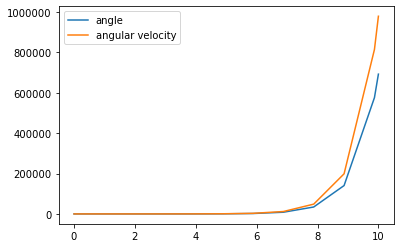

In [11]:
dt = 0.001
g = 9.8
mass = 1.0
length = 1



saturation = lambda x: -3 if x < - 3 else (3 if x > 3 else x)

class Pendulum(FullInformationSystem):
    state_dim = 2
    input_dim = 1

    def __init__(self, mass=1, length=1):
        self.m = mass
        self.l = length

    def drift(self, input):
        return np.array([self.state[1], g * np.sin(self.state[0]) * self.l * self.m + input[0]])

class Pendulum(FullInformationSystem):
    state_dim = 2
    input_dim = 1

    def __init__(self, mass=1, length=1):
        self.m = mass
        self.l = length

    def drift(self, input):
        return np.array([self.state[1], self.state[0] * self.l * self.m + input[0]])

system = Pendulum(mass=mass, length=length)

state_sampler = UniformBoxSampler([-np.pi, np.pi], [-3, 3])
control_sampler = UniformBoxSampler([-10, 10])

lift = PolynomialLift(1)

state_transition = discretize_euler(system, dt=dt)

lift.fit(state_transition=state_transition,
         state_sampler=state_sampler,
         control_sampler=control_sampler,
         n_samples=10000)

x_init = np.array([1, 0.0])

print(lift.terms)

print(lift.predict(x_init, np.array([1])) - x_init, state_transition(x_init, np.array([1])) - x_init)

A = lift.A
B = lift.B

print(A)
print(B)

print(f"Value range in A: {A.min()} -- {A.max()}")
print(f"Value range in B: {B.min()} -- {B.max()}")
print(f"Controllability grammian: {controllability_gramian(A, B)}")

Q = np.eye(A.shape[0])
#Q = np.diag([1] * system.state_dim + [0] * (A.shape[0] - system.state_dim))
R = np.eye(1)



synthesis = LQRDiscreteFH(Q, R, 2)
controller = lift.pullback(synthesis(A, B))

loop = ClosedLoop(system, controller)

t, y = loop.simulate([1.0, 0.0], 10.0)


import matplotlib.pyplot as plt

plt.plot(t, y[0], label="angle")
plt.plot(t, y[1], label="angular velocity")
plt.legend()
plt.show()






